# Monitoring progress with callbacks in JaxPlan.

In many applications, it is desirable to call an optimizer iteratively, monitoring its performance in real time and adjusting as needed. In this notebook, we illustrate how to do this with JaxPlan by showing how to monitor and plot the train and test loss curves across iterations.

Start by installing the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
from IPython.display import Image

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, load_config_from_string

We will use the Quadcopter control problem as an example here:

In [3]:
env = pyRDDLGym.make('Quadcopter', '0', vectorized=True)

Generate a configuration file to load desired hyper-parameters for the planner as usual, and instantiate the planner instance:

In [4]:
config = """
[Model]
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.08}
batch_size_train=1
batch_size_test=1
pgpe=None
[Training]
"""
planner_args, _, train_args = load_config_from_string(config)
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)

[INFO] JAX gradient compiler will cast p-vars {'ID'} to float.
[INFO] Bounds of action-fluent <power> set to (array([[-10000., -10000., -10000., -10000.]], dtype=float32), array([[10000., 10000., 10000., 10000.]], dtype=float32)).


In the current example, we will not instantiate a controller agent, because we will be instructing the planner to optimize ourselves. To do this, we note the ``optimize_generator()`` function in the planner API, which builds a generator that we can iterate through to unravel each step of the optimization sequentially: 

In [5]:
sequence_of_steps = planner.optimize_generator(epochs=8000, print_summary=False, **train_args)

This does not actually begin optimization, because we have not iterated on the resulting iterator. If we do this and inspect the result it yields, we will get a dictionary of information summarizing the iteration. Let's do this now for one iteration and see what kind of information we can extract:

In [6]:
next(sequence_of_steps).keys()

[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /   -19874.00000 train /   -19865.23438 test /   -19865.23438 best / 0 status /      0 pgpe:   6%|▌         | 00:06 , 0.15it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


dict_keys(['status', 'iteration', 'train_return', 'test_return', 'best_return', 'pgpe_return', 'params', 'best_params', 'pgpe_params', 'last_iteration_improved', 'pgpe_improved', 'grad', 'best_grad', 'updates', 'elapsed_time', 'key', 'model_params', 'progress', 'train_log', 'error', 'fluents', 'invariant', 'precondition', 'reward', 'termination'])

As you can see, we can extract a lot of infomation about the optimization, including convergence status, return information, parameters of the plan, gradient information, and even rollouts of the fluents as JAX arrays.

We are interested in monitoring the ``train_return`` and ``test_return`` of each iteration, so let's exhaust the iterator and cache the values at each iteration:

In [7]:
train_returns, test_returns = [], []
for iteration_result in sequence_of_steps:
    train_returns.append(float(iteration_result['train_return'].item()))
    test_returns.append(float(iteration_result['test_return'].item()))

   7999 it /    -5799.12598 train /    -5799.24707 test /    -5795.44141 best / 6 status /      0 pgpe: 100%|██████████| 01:45 , 89.60it/s

Finally, let's plot these time series to assess convergence of the planner:

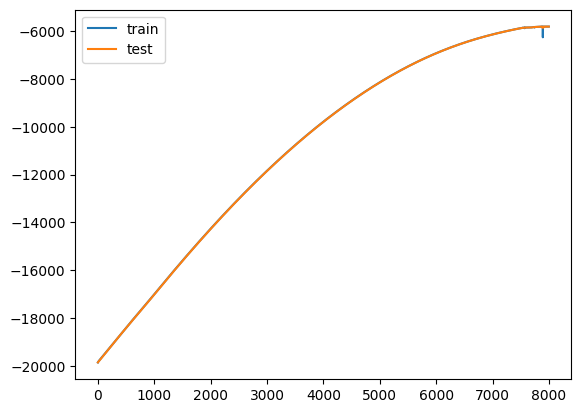

In [9]:
%matplotlib inline
import numpy as np
plt.plot(range(len(train_returns)), np.clip(train_returns, -20000, np.inf), label='train')
plt.plot(range(len(test_returns)), np.asarray(test_returns), label='test')
plt.legend()
plt.show()

As you can see, the planner has converged to an optimal solution. Let's plot the behavior of the plan to make sure:

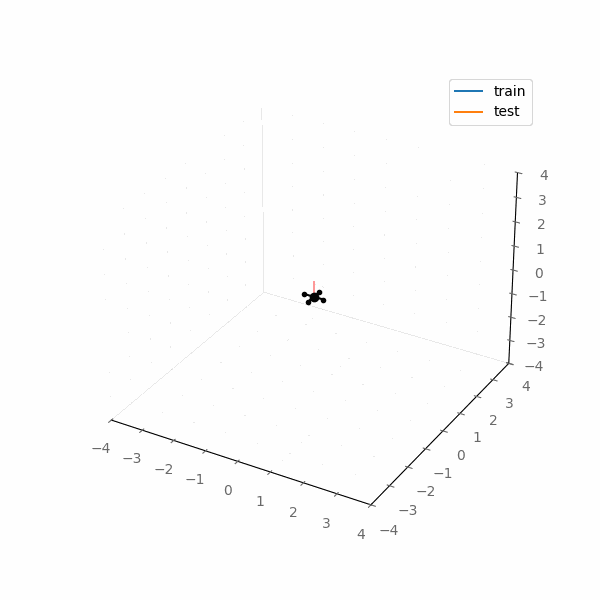

<Figure size 640x480 with 0 Axes>

In [10]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "quadcopter", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)

agent = JaxOfflineController(planner, params=iteration_result['best_params'], **train_args)
agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/quadcopter_0.gif') 